# Notebook

In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from src.util import load_star_galaxy_dataset

## Data

Let's first load the dataset.

In [58]:
star_galaxy = load_star_galaxy_dataset()
star_galaxy.DESCR

'This is a simple dataset consisting of ~3000 64x64 images of stars and ~1000 images of galaxies. The images were captured by the in-house 1.3m telescope of the observatory situated in Devasthal, Nainital, India.'

Now, let's take a peek at some of the images in the dataset.

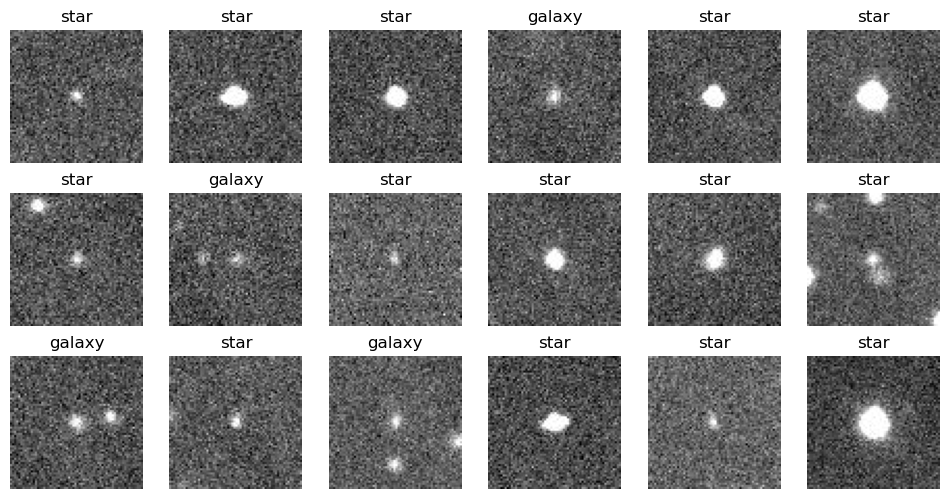

In [62]:
w, h = 6, 3

_, axs_list = plt.subplots(h, w, figsize=(2 * w, 2 * h))

_i = 0
indices = np.random.choice(len(star_galaxy.data), size=(h * w))
for axs in axs_list:
    for ax in axs:
        i = indices[_i]
        ax.axis("off")
        img = star_galaxy.data[i].reshape((64, 64))
        ax.imshow(img, cmap="gray")
        ax.set_title(star_galaxy.target_names[star_galaxy.target[i]])
        _i += 1